# Introduction

This notebook is used for generating `interaction.csv`.

# Utils

In [2]:
import os
import uuid
import utils
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from itertools import permutations, combinations
from sklearn.model_selection import train_test_split

PROJECT_DIR = "."
SOURCES_DIR = os.path.join(PROJECT_DIR, "sources")
DATASETS_DIR = os.path.join(PROJECT_DIR, "datasets")

# Data Preparation

In [2]:
nosh_products = utils.read_nosh_products(os.path.join(SOURCES_DIR, "nosh_product_data.xlsx"))

In [3]:
nosh_products.head()

,product_id,product,shelf_life,usual_storage
0,1,spaghetti,NaN,pantry
1,2,onion,13.0,pantry
2,3,sugar,NaN,pantry
3,4,mustard,60.0,pantry
4,5,tomato sauce,NaN,pantry


In [4]:
def read_purchase_sequences(filepath):
    df = pd.read_csv(filepath)
    df['purchase_sequence'] = df['purchase_sequence'].str.split(",")
    return df

purchase_sequences = read_purchase_sequences(os.path.join(DATASETS_DIR, "purchase_sequences.csv"))

In [5]:
purchase_sequences.head()

,purchase_sequence
0,"[141, 86, 38]"
1,"[141, 38, 116, 37]"
2,"[161, 180]"
3,"[161, 161]"
4,"[51, 186, 141, 116]"


# Build Model

To generate the interaction data, this project borrows method from NLP. In particular, this project uses Ngram to predict the next purchase based on the purchase sequences in the train set.

In [6]:
class PurchaseNgram:
    def __init__(self, sequences, products, n=3, padding='<PADDING>'):
        self.n = n
        self.padding = padding
        self.products = products
        self.sequences = sequences
        self.ngrams = {i: {} for i in range(1, n+1)}
    
    def build(self):
        for seq in tqdm(self.sequences):
            seq = [self.padding] * (self.n - len(seq)) + seq
            for k in range(1, self.n+1):
                for perm in permutations(seq, k):
                    if perm in self.ngrams[k].keys():
                        self.ngrams[k][perm] += 1
                    else:
                        self.ngrams[k][perm] = 1
                        
        print("-- model builts")
    
    def predict(self, prompt, top=20, rand=0.3):
        
        if len(prompt) <= self.n-2:
            prompt = [self.padding] * (self.n-1 - len(prompt)) + prompt
        elif len(prompt) > self.n:
            prompt = prompt[-self.n:]
                        
        results = []
        
        for product in self.products:
            p = tuple(prompt) + (str(product),)
            
            try:
                res = {
                    "product": product,
                    "score": (self.ngrams[self.n][p]) / (self.ngrams[self.n-1][tuple(prompt)] + 1e-5)
                }
            except:
                res = {
                    "product": product,
                    "score": 0.0
                }
            
            results.append(res)
                
        results = sorted(results, key=lambda x: x['score'], reverse=True)[:top]
        
        if random.random() < rand:
            random.shuffle(results)
        
        return results

# Generate Interactions Data

Here an 4-Gram is used to generate the next item.

In [8]:
model = PurchaseNgram(
    n=4,
    products=list(nosh_products['product_id'].unique()),
    sequences=purchase_sequences['purchase_sequence'].to_list(),
)
model.build()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13646/13646 [00:00<00:00, 16206.65it/s]

-- model builts


The below code cell generate interactions for `num_customers` where each customer has `num_sessions_per_customer` sessions.

In [9]:
# read product count distribution for randomly picking leading product
product_count_dist = pd.read_csv(os.path.join(os.path.join(DATASETS_DIR, 'product_count_dist.csv')))
product_count_dist['count'] = (product_count_dist['count'] / product_count_dist['count'].sum()) * 100

# read purchase count distribution for randomly picking how many purchase/interactions to make in a session
purchase_count_dist = pd.read_csv(os.path.join(DATASETS_DIR, 'purchase_count_dist.csv'))
purchase_count_dist['value'] = (purchase_count_dist['value'] / purchase_count_dist['value'].sum()) * 100
purchase_count_dist = purchase_count_dist[purchase_count_dist['count'] != 1]

num_sessions_per_customer = 1000
num_customers = 400

result = []

for customer_id in tqdm(range(num_customers)):
    for _ in range(num_sessions_per_customer):
        session_id = uuid.uuid4()
        
        num_products_in_session = random.choices(
            purchase_count_dist['count'].to_list(),
            weights=purchase_count_dist['value'].to_list(),
            k=1
        )[0]

        leading_prods = [
            str(
                # randomly pick a product as a leading product.
                random.choices(
                    product_count_dist['product_id'].to_list(),
                    product_count_dist['count'].to_list(),
                    k=1
                )[0]
            )
        ]

        for i in range(num_products_in_session-1):
            leading_prods += [str(model.predict(leading_prods, rand=0.3)[0]['product'])]
        
        result.append({
            "session_id": session_id,
            "user_id": customer_id,
            "purchase_sequence": leading_prods
        })
        
temp = pd.DataFrame(result).explode('purchase_sequence')\
                    .rename(columns={"purchase_sequence": "product_id"})

temp.to_csv('datasets/interactions.csv', index=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [03:21<00:00,  1.99it/s]


# Create Train/Test Split

In [6]:
temp = pd.read_csv(os.path.join(DATASETS_DIR, "interactions.csv"))
selected_session = temp.drop('product_id', axis=1)\
                    .drop_duplicates()\
                    .groupby('user_id')['session_id']\
                    .sample(int(1000 * 0.2)).to_frame('session_id')\
                    .reset_index(drop=True)['session_id']\
                    .to_list()

train_set = temp[~temp['session_id'].isin(selected_session)]
test_set = temp[temp['session_id'].isin(selected_session)]

train_set.to_csv(os.path.join(DATASETS_DIR, 'interactions_train.csv'), index=False)
test_set.to_csv(os.path.join(DATASETS_DIR, 'interactions_test.csv'), index=False)

# Visualising the result

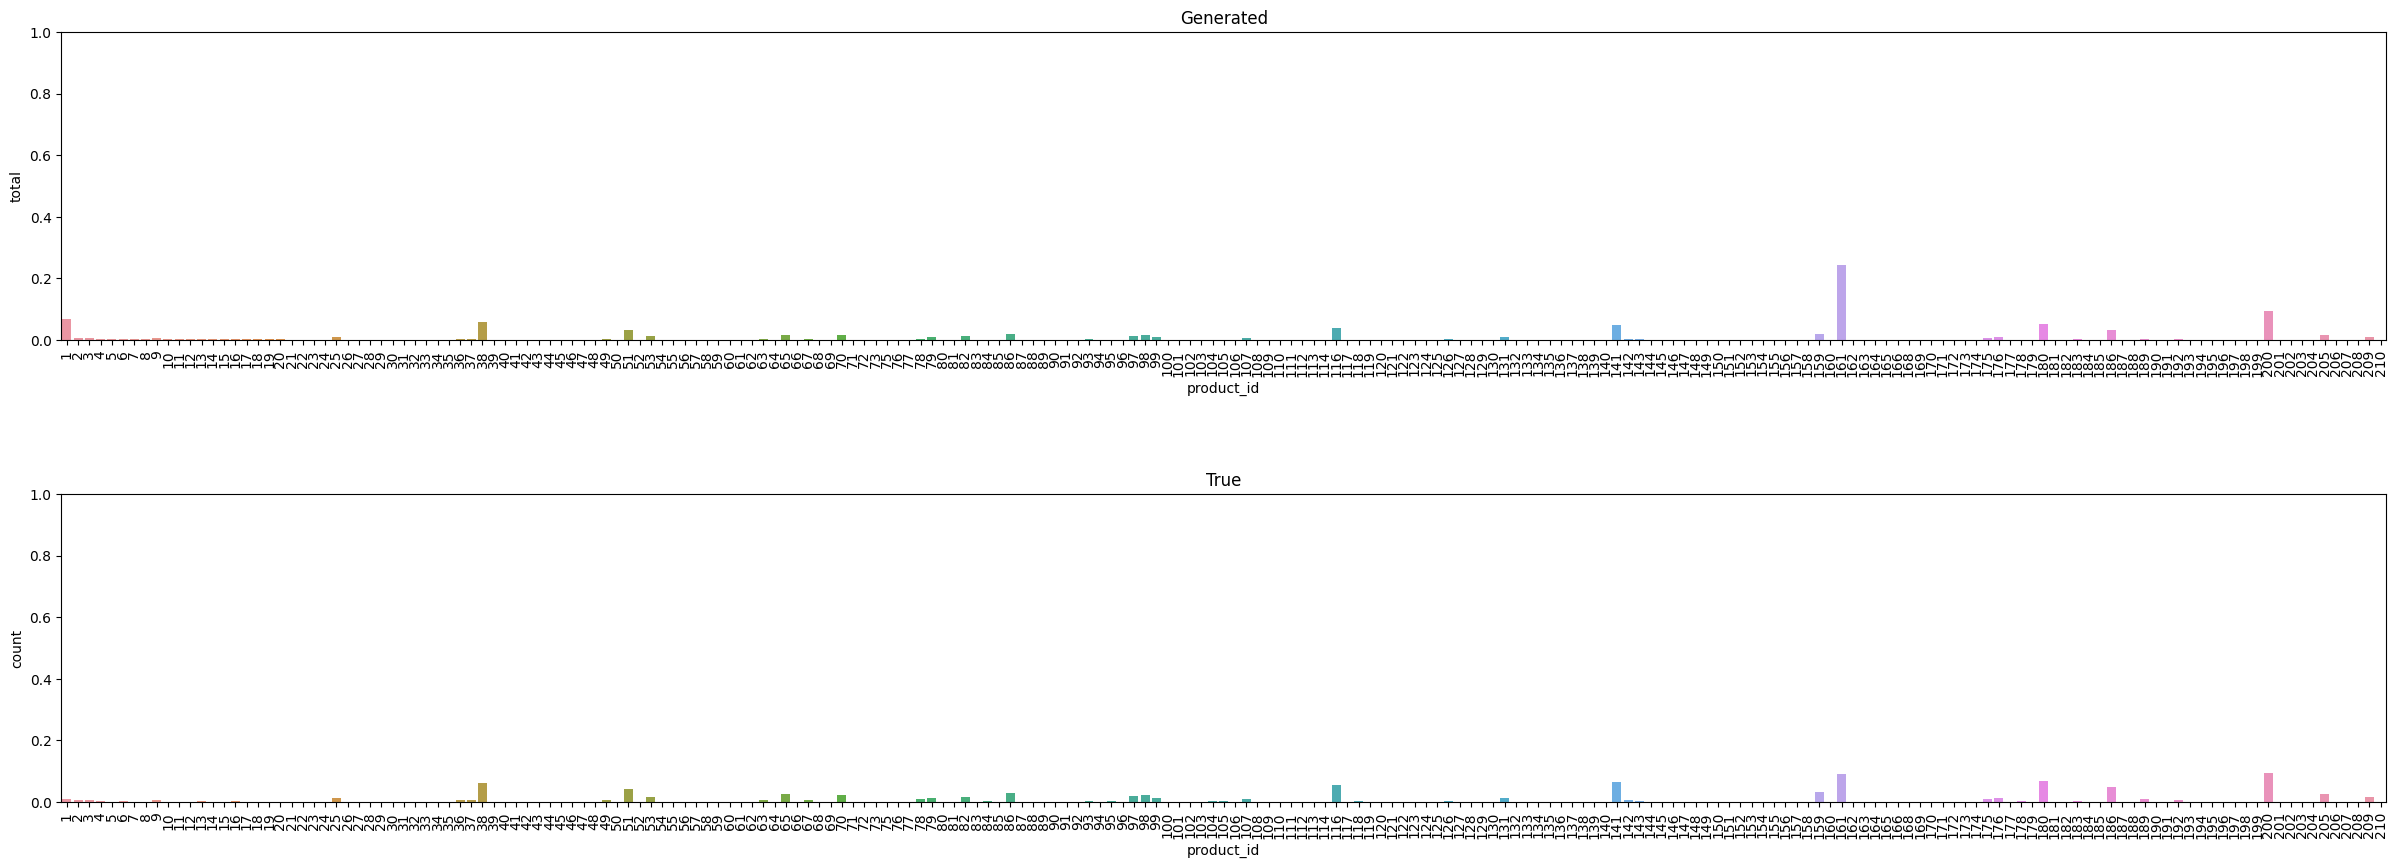

In [10]:
fig = plt.figure(figsize=(30, 10))

fig.subplots_adjust(hspace=0.5, wspace=0)

plt.subplot(2, 1, 1)
# plot generated interaction distribution
temp = pd.read_csv(os.path.join(DATASETS_DIR, "interactions.csv"))
temp = temp.groupby(['product_id'])['product_id'].count().to_frame(name = 'total').reset_index()
temp['total'] = temp['total'] / temp['total'].sum()

sns.barplot(data=temp, x='product_id', y='total')
_ = plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.title("Generated")

plt.subplot(2, 1, 2)
# plot real interaction distribution
temp = pd.read_csv(os.path.join(DATASETS_DIR, "product_count_dist.csv"))
temp['count'] = temp['count'] / temp['count'].sum()
sns.barplot(data=temp, x='product_id', y='count')
_ = plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.title("True")

plt.show()

Let's also see if the products bought in a session make sense

In [11]:
temp = pd.read_csv(os.path.join(DATASETS_DIR, "interactions.csv"))
temp = temp.merge(right=nosh_products, left_on='product_id', right_on='product_id', how='left')
temp = temp[['session_id', 'user_id', 'product']]

temp.head()

,session_id,user_id,product
0,05834b79-b5dc-4dde-a134-42056d335f39,0,cooked noodles
1,05834b79-b5dc-4dde-a134-42056d335f39,0,shortcrust pastry
2,1e36c1a9-b736-4e27-b0cd-6dcf99b22146,0,spaghetti
3,1e36c1a9-b736-4e27-b0cd-6dcf99b22146,0,cheese
4,1e36c1a9-b736-4e27-b0cd-6dcf99b22146,0,canned tuna


In [12]:
temp.groupby(['session_id', 'user_id'])['product'].agg(list).to_frame(name='purchases').reset_index()

,session_id,user_id,purchases
0,000057e1-b8b5-4614-92c5-3385ac527c83,357,"[canned tuna, blueberries, chocolate breakfast..."
1,000098b2-5a88-48a6-8bff-d0c9d8bd9bc0,4,"[beer, beer, chocolate breakfast cereal]"
2,0000d2be-c7de-464f-acaa-3c8734d69221,37,"[milk, beer]"
3,00011e6e-4f4d-43f8-ac0d-d4d2002e88fe,98,"[sliced mushroom, bread slice]"
4,0001364e-c06f-4613-b395-06fb4abd06c6,278,"[fruit juice, beer]"
...,...,...,...
399995,ffff0f9b-57ff-4a5b-8bb6-5be2491ce3a1,194,"[sausage meat, beer, cooked mixed vegetables, ..."
399996,ffff1c7e-fb0f-497b-a4bb-9ca6d9da759d,180,"[cooked noodles, tortilla wraps]"
399997,ffff5034-8198-4f0d-bd42-d4e57660144a,131,"[peanut butter, flour]"
399998,ffff5664-eedb-40b0-ba74-21eefc000cac,397,"[salt, sausage meat]"
